In [10]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject


# 1. Data Loading

We load the Beijing traffic speed dataset from a CSV file and the adjacency matrix from a pickle file.  
The speed data record the average speed of vehicle on major roads in Beijing.  
The adjacency matrix represents the connectivity between different traffic nodes.

In [7]:
beijing = pd.read_csv('data/Beijing/data.csv', index_col=0, date_parser=[0])
with open('data/Beijing/adj.pkl', 'rb') as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f)
assert len(beijing.columns) == len(sensor_ids) == adj_mx.shape[0] == adj_mx.shape[1]
print('Loading Beijing Dataset Successful')

---

# 2. Data Quality Assessment

## 2.1 Basic Information

The following section provides a snapshot of the fundamental aspects of the Beijing traffic speed dataset:

In [55]:
print('\033[1m-------Fundamental Information of the Dataset-------\033[0m\n')
print('Data Shape:      {}\n'.format(beijing.shape))
print('Node Number:     {}\n'.format(len(beijing.columns)))
print('Data Time Range: {}~{}'.format(beijing.index[0], beijing.index[-1]))
number_of_timestamps = beijing.shape[0]
print('Observed Times:  {}'.format(number_of_timestamps))
time_deltas = beijing.index.to_series().diff().dropna().dt.total_seconds() / 60
print('Time Resolution: {} minutes'.format(time_deltas.unique()[0]))
unique_days = pd.to_datetime(beijing.index).normalize().nunique()
print('Observed Days:   {} days\n'.format(unique_days))
print('Data Range:      {}km/h-{}km/h\n'.format(beijing.min().min(), beijing.max().max()))
print('\033[1m----------------------------------------------------\033[0m')

-------Fundamental Information of the Dataset-------

Data Shape:      (21600, 3126)

Node Number:     3126

Data Time Range: 2022-05-12 00:00:00~2022-07-25 23:55:00
Observed Times:  21600
Time Resolution: 5.0 minutes
Observed Days:   75 days

Data Range:      0.0km/h-120.0km/h

----------------------------------------------------


## 2.2 Statistical Information

### 2.2.1 Missing Values

Note that the missing data has been filled with zeros.

In [61]:
beijing[beijing.isnull().T.any()]

,0,1,2,3,4,5,6,7,8,9,...,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125
time,,,,,,,,,,,,,,,,,,,,,


Four hours of data are missing.  
2022-06-01 16:00:00  
2022-06-25 22:00:00	
2022-07-17 18:00:00	
2022-07-17 22:00:00

In [182]:
is_zero = (beijing == 0)
all_zeros = is_zero.all(axis=1)
beijing[all_zeros]

,0,1,2,3,4,5,6,7,8,9,...,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125
time,,,,,,,,,,,,,,,,,,,,,
2022-06-01 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-01 16:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2.2 Distributions

In [85]:
all_values = beijing.values.flatten()
percentiles = [0.1, 0.5, 0.9]
desc_stats = {
    '10%': np.percentile(all_values, 10),
    '25%': np.percentile(all_values, 25),
    '50%': np.percentile(all_values, 50),
    '75%': np.percentile(all_values, 75),
    '90%': np.percentile(all_values, 90),
    'Mean': np.mean(all_values),
    'Min': np.min(all_values),
    'Max': np.max(all_values),
    'Std': np.std(all_values)
}

print('\033[1m-------Speed Data Statistics-------\033[0m\n')
for key, value in desc_stats.items():
    print(f"{key}: {value:.2f}")
print('\n\033[1m-----------------------------------\033[0m')

-------Speed Data Statistics-------

10%: 42.55
25%: 57.00
50%: 67.12
75%: 73.00
90%: 77.29
Mean: 62.70
Min: 0.00
Max: 120.00
Std: 15.58

-----------------------------------


### 2.2.3 Adjacency Matrix

In [82]:
print('\033[1m----------Adjacency Matrix Statistics----------\033[0m\n')
degrees = adj_mx.sum(axis=1)
print('Average Degree of Connectivity per Node: {:.4f}'.format(np.mean(degrees)))
print('Minimum Degree of Connectivity per Node: {}'.format(degrees.min()))
print('Maximum Degree of Connectivity per Node: {}'.format(degrees.max()))
sparsity = 1.0 - (np.count_nonzero(adj_mx) / (len(sensor_ids)**2))
print('Sparsity of the Network: {:.4f}'.format(sparsity))
print('\n\033[1m-----------------------------------------------\033[0m')

----------Adjacency Matrix Statistics----------

Average Degree of Connectivity per Node: 2.0729
Minimum Degree of Connectivity per Node: 1.0
Maximum Degree of Connectivity per Node: 4.0
Sparsity of the Network: 0.9993

-----------------------------------------------


---

# 3. Data Visualization

## 3.1 Sample Nodes Speed

### 3.1.1 Speed Time Series

To gain a clearer understanding of traffic speed variations over time across different locations, we visualize the time series data for a sample of nodes.

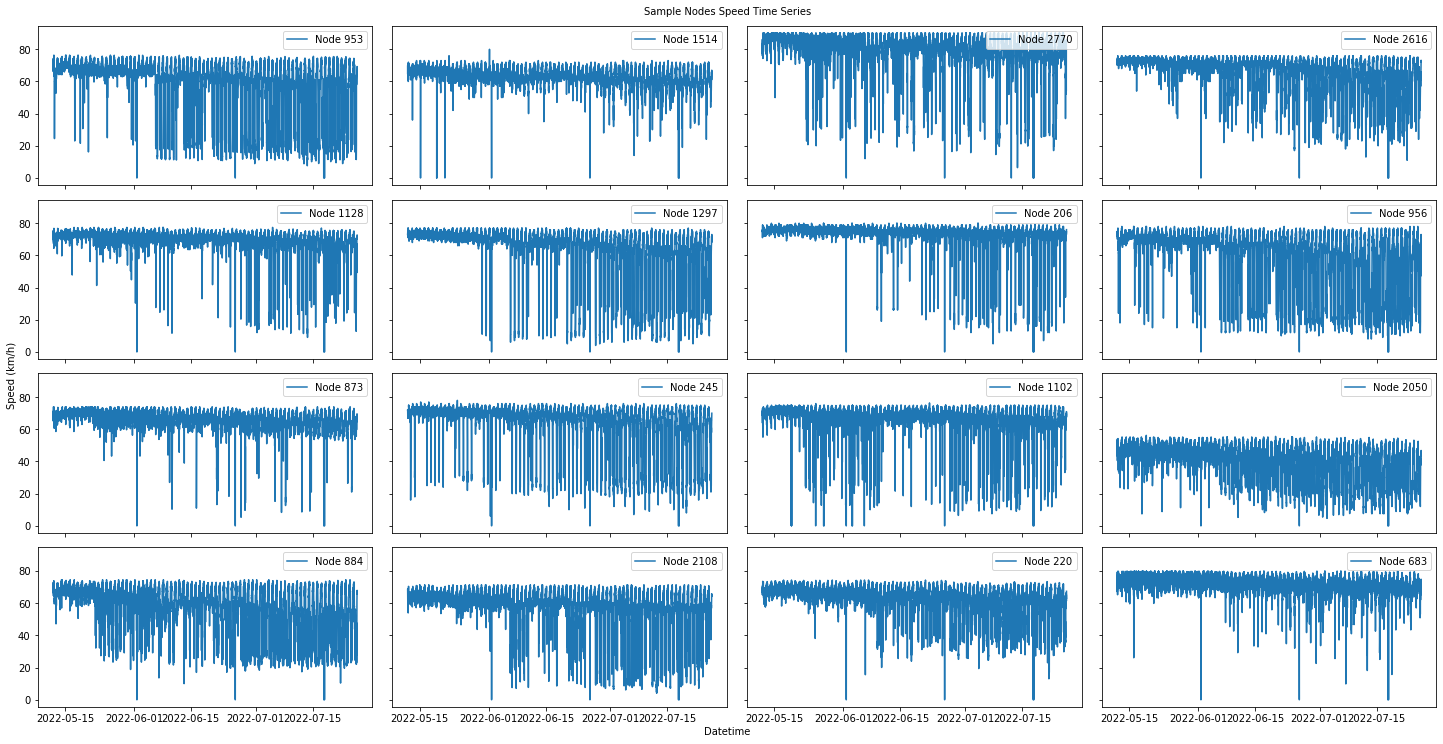

In [110]:
sample_nodes = np.random.choice(sensor_ids, size=16, replace=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, node in enumerate(sample_nodes):
    axes[i].plot(beijing.index, beijing[node], label='Node ' + node)
    axes[i].legend(loc='upper right')
fig.suptitle('Sample Nodes Speed Time Series', fontsize=16)
fig.text(0.5, 0, 'Datetime', ha='center')
fig.text(0, 0.5, 'Speed (km/h)', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

### 3.1.2 Daily Speed

Sample nodes from above to see their daily speed aggregation.

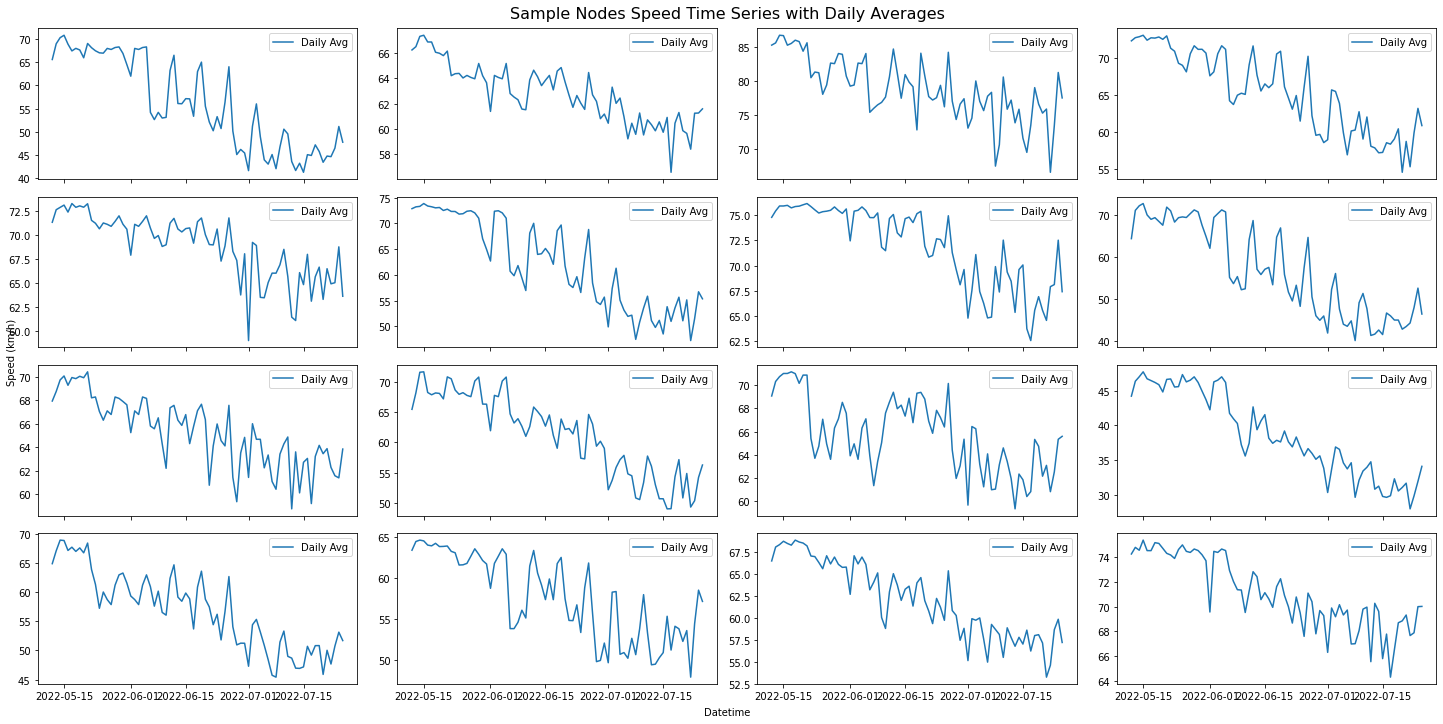

In [159]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, node in enumerate(sample_nodes):
    hourly_average = beijing[node].resample('D').mean()
    axes[i].plot(hourly_average.index, hourly_average, label='Daily Avg')
    axes[i].legend(loc='upper right')
fig.suptitle('Sample Nodes Speed Time Series with Daily Averages', fontsize=16)
fig.text(0.5, 0, 'Datetime', ha='center', va='center')
fig.text(0, 0.5, 'Speed (km/h)', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

### 3.1.3 Speed Decomposition

Sample nodes from above to see their time series decomposition results.

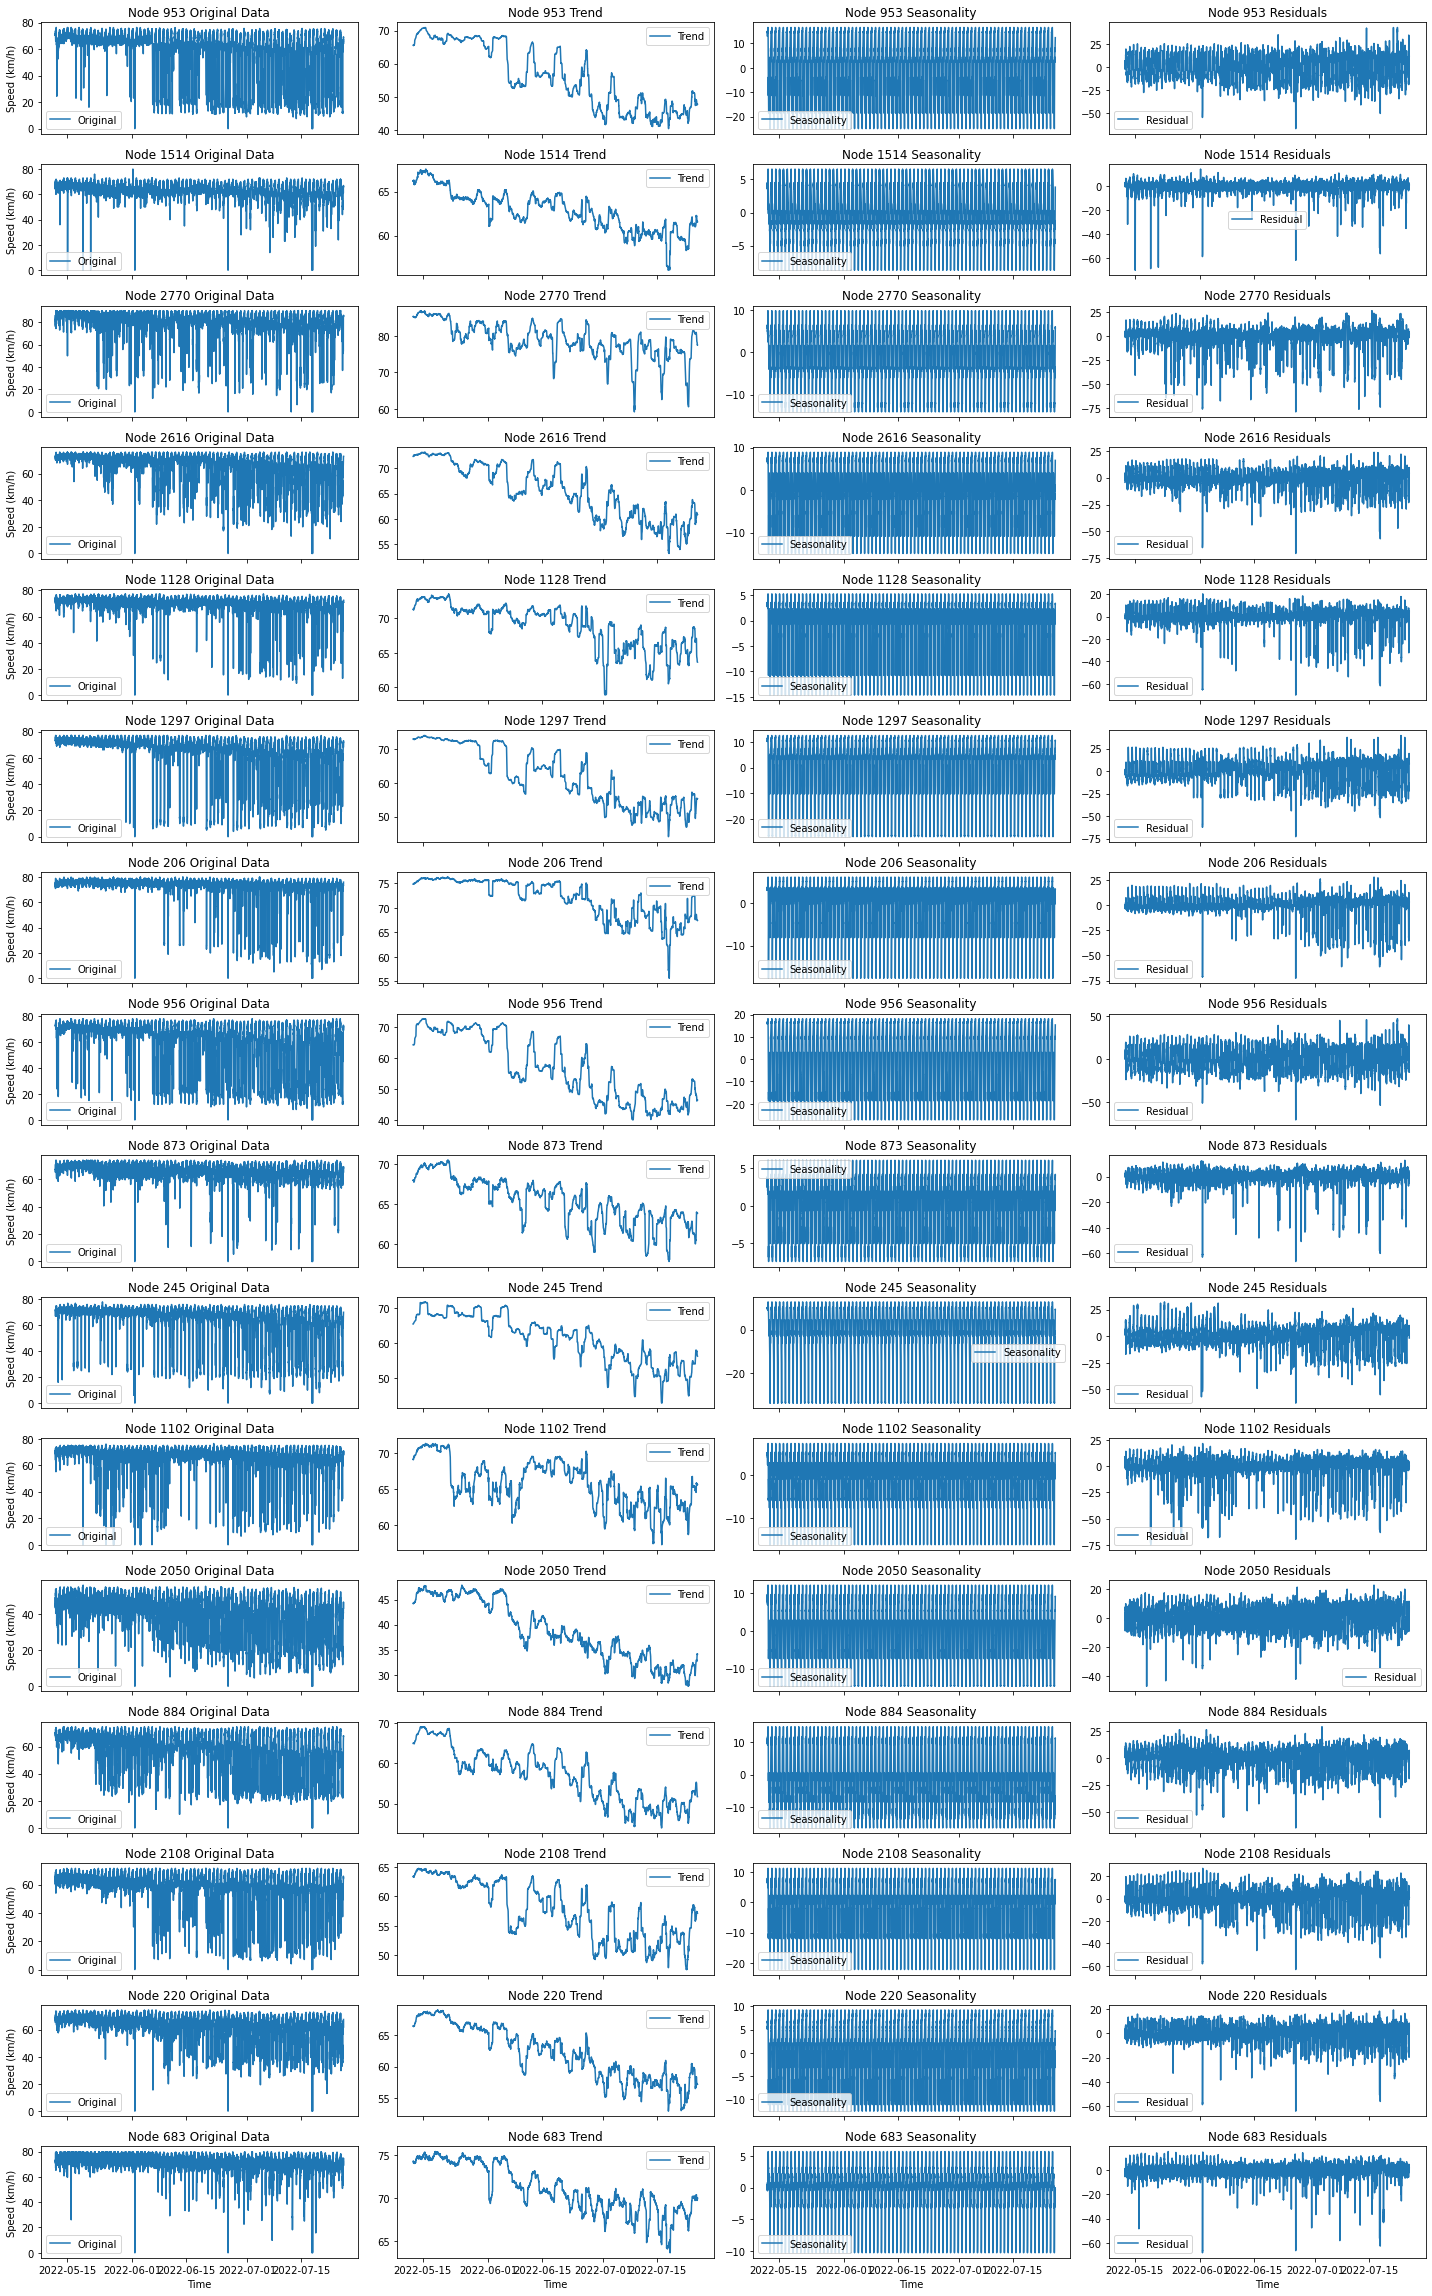

In [169]:
rows = len(sample_nodes)
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows), sharex=True)
for i, node in enumerate(sample_nodes):
    decomposition = seasonal_decompose(beijing[node], model='additive', period=288)
    
    axes[i, 0].plot(decomposition.observed, label='Original')
    axes[i, 0].legend(loc='best')
    axes[i, 0].set_title(f'Node {node} Original Data')
    
    axes[i, 1].plot(decomposition.trend, label='Trend')
    axes[i, 1].legend(loc='best')
    axes[i, 1].set_title(f'Node {node} Trend')
    
    axes[i, 2].plot(decomposition.seasonal, label='Seasonality')
    axes[i, 2].legend(loc='best')
    axes[i, 2].set_title(f'Node {node} Seasonality')
    
    axes[i, 3].plot(decomposition.resid, label='Residual')
    axes[i, 3].legend(loc='best')
    axes[i, 3].set_title(f'Node {node} Residuals')

for ax in axes[:, 0]:
    ax.set_ylabel('Speed (km/h)')
for ax in axes[-1, :]:
    ax.set_xlabel('Time')

fig.tight_layout()
plt.show()

## 3.2 City-wide Speed Quartile

Check the daily quartile change in traffic speeds on the entire city's roads.

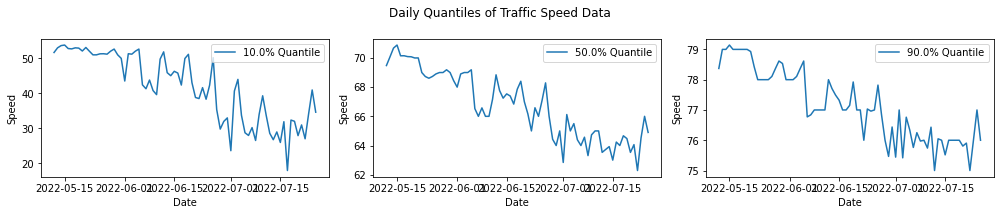

In [147]:
quantiles = [0.1, 0.5, 0.9] 
quantile_df = pd.DataFrame(index=beijing.index.normalize().unique())

for q in quantiles:
    daily_quantile = beijing.resample('D').apply(lambda x: x.values.flatten()).apply(lambda x: np.quantile(x, q))
    quantile_df[f'{q * 100}%'] = daily_quantile.values.flatten()

fig, axes = plt.subplots(nrows=1, ncols=len(quantiles), figsize=(14, 3), sharex=True)
for i, q in enumerate(quantile_df.columns):
    axes[i].plot(quantile_df.index, quantile_df[q], label=f'{q} Quantile')
    axes[i].legend(loc='upper right')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Speed')
fig.suptitle('Daily Quantiles of Traffic Speed Data')
plt.tight_layout()
plt.show()

## 3.3 City-wide Speed Distribution

Check the distribution of traffic speeds across the city before and after particular moments.

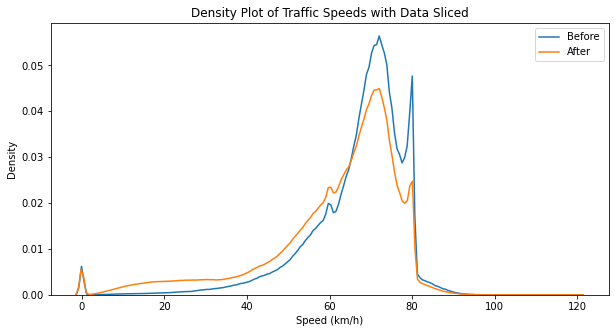

In [170]:
before_change = beijing[:'2022-06-05']
after_change = beijing['2022-06-06':]

plt.figure(figsize=(10, 5))
sns.kdeplot(before_policy_change.stack(), label='Before')
sns.kdeplot(after_policy_change.stack(), label='After')
plt.title('Density Plot of Traffic Speeds with Data Sliced')
plt.xlabel('Speed (km/h)')
plt.legend()
plt.show()

---